# Reinforcement learning: Q-learning for terrain path planning optimizacion for a 4 legged robot

## Cell 1

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

rows, cols = 10, 10
start = (0, 5)
goal = (rows - 1, cols - 1)
max_reward = 30


penalty_scale_factor = 0.1  # Reduce the penalties by this factor

# Define penalties for different soil types, based on distance to bedrock
soil_penalties = {
    'Bedrock_0': 0,
    'Bedrock_1': 0,
    'Bedrock_2': 0,
    'Coarse_Sand_0': 1,
    'ES-3_0': 1,
    'ES-2_0': 1,
    'Bedrock_ES-2_0': 1,
    'Rocks_on_ES-3_2': 1,
    'ES-1_1': 1,
    'Rocks_on_ES-3_1': 2,
    'ES-3_1': 2,
    'Coarse_Sand_1': 2,
    'ES-3_2': 3,
    'Coarse_Sand_2': 3,
    'ES-1_0': 3,
    'Rocks_on_ES-3_0': 4,
    'ES-2_2': 4,
    'ES-2_1': 4,
    'ES-1_2': 5,
    'Bedrock_ES-2_1': 5,
    'Bedrock_ES-2_2': 5,
}

np.random.seed(0)
soil_types = list(soil_penalties.keys())
soil_grid = np.full((rows, cols), 'Bedrock_0', dtype='U15')

# Create a path with optimal soil types
for r in range(rows):
    for c in range(max(0, r-1), min(cols, r+2)):
        soil_grid[r, c] = np.random.choice(['Bedrock_0', 'Bedrock_1', 'Bedrock_2'])

# Surround the path with other soil types
for r in range(rows):
    for c in range(cols):
        if soil_grid[r, c] == 'Bedrock_0':
            soil_grid[r, c] = np.random.choice(soil_types)

# Initialize penalties grid
penalties = np.full((rows, cols), 1)  # Default small penalty
for i in range(rows):
    for j in range(cols):
        soil_type = soil_grid[i, j]
        penalties[i, j] = soil_penalties[soil_type]

penalties[start] = 0
penalties[goal] = max_reward  # Significant reward at the goal

# Initialize Q-table
Q = np.zeros((rows, cols, 4))

# Define actions
actions = ['up', 'right', 'down', 'left']

## Cell 2

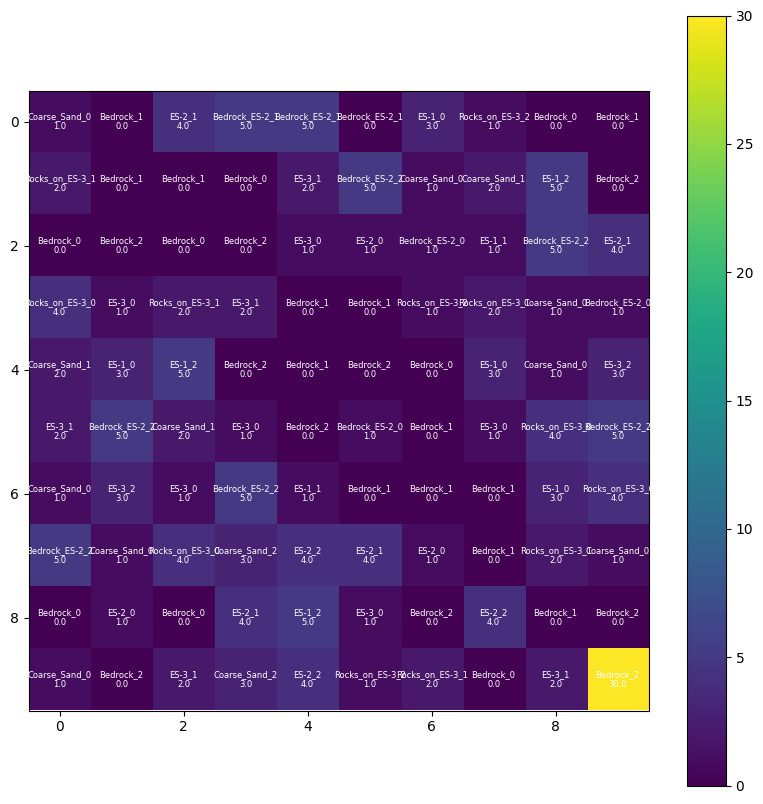

In [75]:
def visualize_grid():
    fig, ax = plt.subplots(figsize=(10, 10))
    # Adjust the color map and normalization
    norm = plt.Normalize(vmin=np.min(penalties), vmax=np.max(penalties))
    im = ax.imshow(penalties, cmap='viridis', norm=norm, interpolation='nearest')
    
    # Annotate each cell with the soil type and penalty
    for i in range(rows):
        for j in range(cols):
            soil_type = soil_grid[i, j]
            penalty = penalties[i, j]
            text = ax.text(j, i, f'{soil_type}\n{penalty:.1f}',
                           ha='center', va='center', color='white', fontsize=6)
    plt.colorbar(im)  # Add a color bar for reference
    plt.show()

visualize_grid()


## Cell 3

In [76]:
def is_terminal_state(state):
    return state == goal

def get_starting_location():
    return start

def choose_action(state, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(len(actions))
    else:
        return np.argmax(Q[state])

def take_step(state, action_index):
    i, j = state
    if actions[action_index] == 'up' and i > 0:
        i -= 1
    elif actions[action_index] == 'right' and j < cols - 1:
        j += 1
    elif actions[action_index] == 'down' and i < rows - 1:
        i += 1
    elif actions[action_index] == 'left' and j > 0:
        j -= 1
    return (i, j)

def display_grid(state, episode, step, total_score, path=None):
    grid = np.zeros((rows, cols, 3))
    
    for r in range(rows):
        for c in range(cols):
            if (r, c) == start:
                grid[r, c] = [0, 1, 0]  # Start in green
            elif (r, c) == goal:
                grid[r, c] = [1, 0, 0]  # Goal in red
            elif (r, c) in path:
                grid[r, c] = [0, 0, 1]  # Path in blue
            else:
                penalty = penalties[r, c]
                grid[r, c] = [1 - penalty / max_reward, 1, 1 - penalty / max_reward]  # Different shades for soil types

    clear_output(wait=True)
    plt.imshow(grid)
    plt.title(f'Episode: {episode+1} Step: {step} Total Score: {total_score}')
    plt.show()

## Cell 4

In [77]:
# Q-Learning Training Loop with Data Collection

start_score = 20
learning_rate = 0.5
discount_factor = 0.9
epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.01
success_count = 0

total_rewards_per_episode = []  # Store total rewards per episode
steps_per_episode = []  # Store steps taken per episode

# Initialize Q-table with zeros
Q = np.zeros((rows, cols, 4))

# Training loop
for episode in range(50):
    state = get_starting_location()
    total_reward = 0
    steps = 0
    done = False

    while not done:
        action_index = choose_action(state, epsilon)
        next_state = take_step(state, action_index)
        
        reward = -penalties[next_state] if next_state != goal else penalties[next_state]
        total_reward += reward
        steps += 1

        if not is_terminal_state(next_state):
            old_q_value = Q[state + (action_index,)]
            future_q = np.max(Q[next_state])
            Q[state + (action_index,)] = old_q_value + learning_rate * (reward + discount_factor * future_q - old_q_value)
        else:
            done = True
            Q[state + (action_index,)] = reward
            if next_state == goal:
                success_count += 1

        state = next_state
        epsilon = max(epsilon - epsilon_decay, min_epsilon)

    total_rewards_per_episode.append(total_reward)
    steps_per_episode.append(steps)

    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episode {episode}: Current score = {total_reward}")

print(f"Total successful episodes: {success_count}")


Episode 0: Current score = -6100
Total successful episodes: 50


## Cell 5

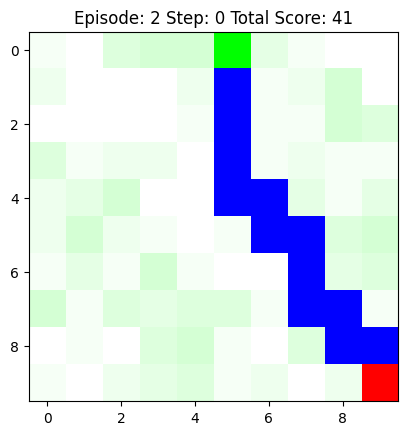

Final state: (9, 9), Total score: 41


In [78]:
def evaluate_model():
    state = get_starting_location()
    total_score = start_score
    step = 0
    done = False
    path = [state]  # Initialize path list to track the path

    while not done and state != goal:
        action_index = np.argmax(Q[state])
        state = take_step(state, action_index)
        path.append(state)  # Add state to the path
        
        reward = -penalties[state] if state != goal else penalties[state]
        total_score += reward
        display_grid(state, 1, step, total_score, path)  # Include path in visualization
        time.sleep(0.5)  # Pause for visualization

        if is_terminal_state(state):
            done = True

    print(f"Final state: {state}, Total score: {total_score}")

evaluate_model()

## Cell 6

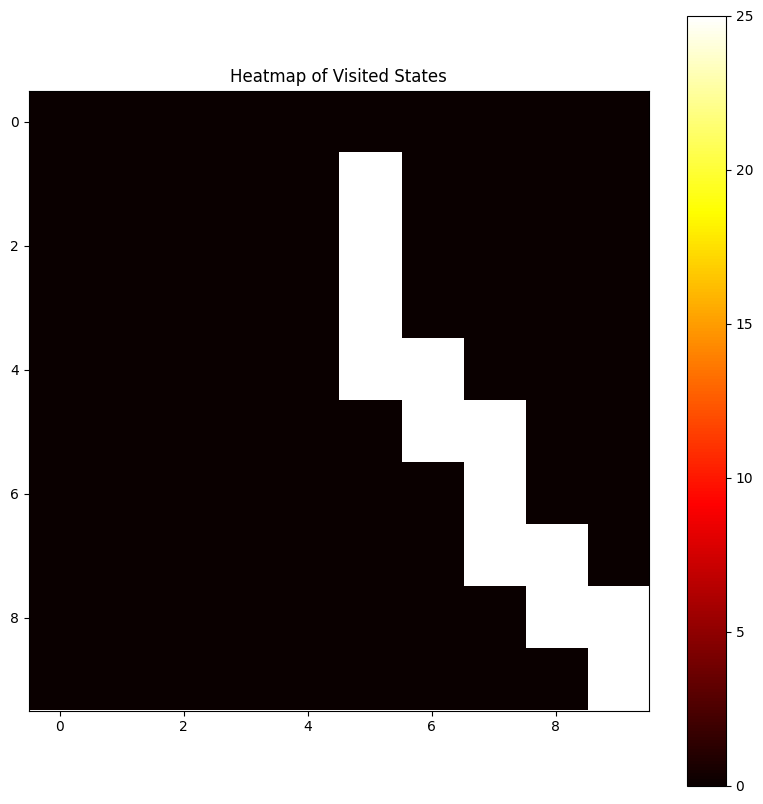

In [79]:
# Assuming this code is added after the training loop in Cell 4

# Initialize a visits grid
visits = np.zeros((rows, cols))

# Simulate multiple runs to fill the visits grid
for _ in range(25):
    state = get_starting_location()
    done = False
    while not done:
        action_index = np.argmax(Q[state])
        state = take_step(state, action_index)
        visits[state] += 1
        if state == goal:
            break

# Plot the heatmap
plt.figure(figsize=(10, 10))
plt.imshow(visits, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Heatmap of Visited States")
plt.show()


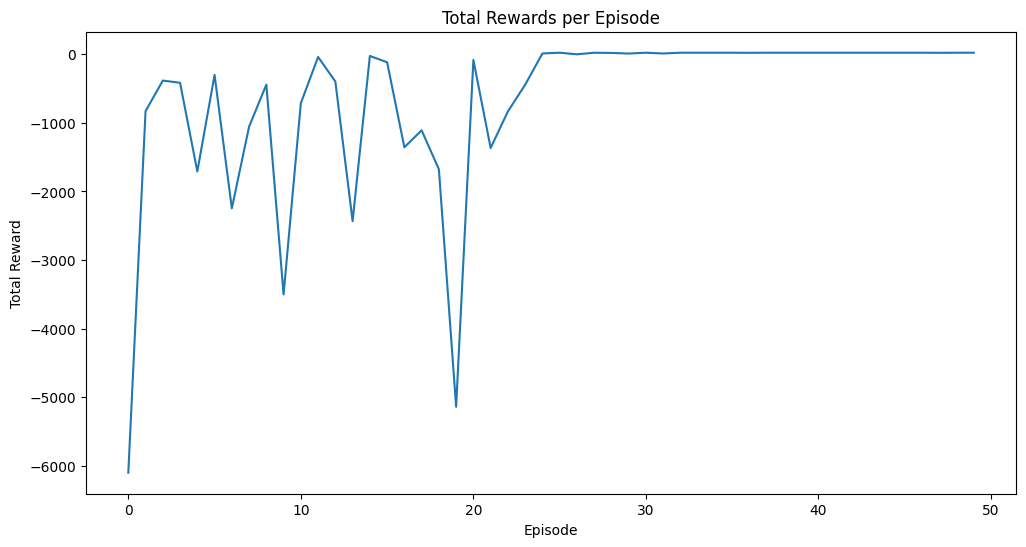

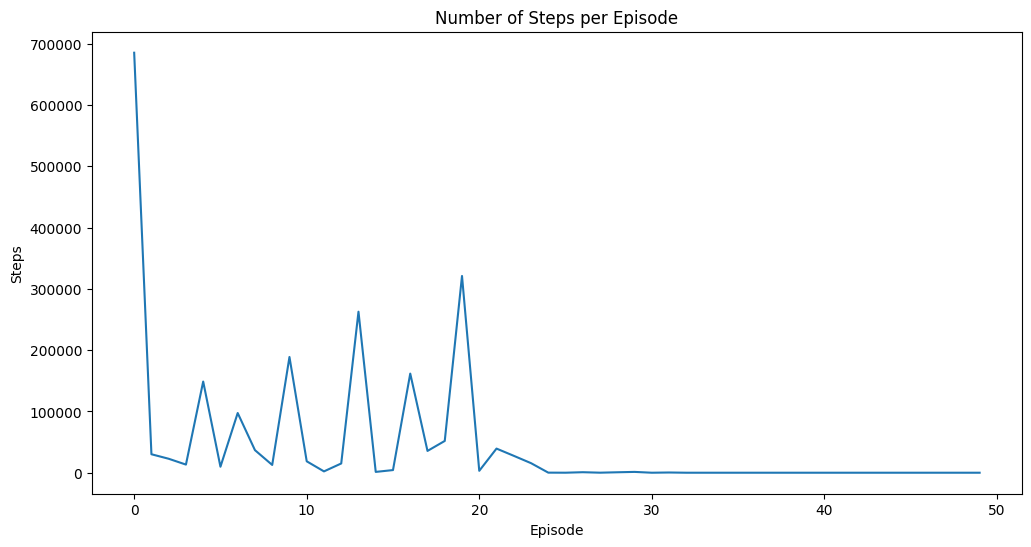

In [80]:
# New Cell: Analysis of Training Data

import matplotlib.pyplot as plt

# Plotting the total rewards per episode
plt.figure(figsize=(12, 6))
plt.plot(total_rewards_per_episode)
plt.title("Total Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

# Plotting the number of steps per episode
plt.figure(figsize=(12, 6))
plt.plot(steps_per_episode)
plt.title("Number of Steps per Episode")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.show()
